# Salary Premium Analysis

#### This notebook quantifies how much each skill adds to salary, controlling for noise as much as possible.

### Load and clean base dataset

In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

df = pd.read_csv("combined_with_skills_norm_v1.csv")

def parse_skills(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    return []

df["skills_norm"] = df["skills_norm"].apply(parse_skills)

df = df[
    (df["salary_final"].notna()) &
    (df["salary_final"] > 10000) &
    (df["skills_norm"].apply(len) > 0)
]


/tmp/ipython-input-2746523253.py:5: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("combined_with_skills_norm_v1.csv")


### Compute Global Average Salary

In [2]:
global_avg_salary = df["salary_final"].mean()
global_avg_salary

np.float64(108243.56547542046)

### Explode skills (job–skill pairs)

In [3]:
df_exploded = df[["salary_final", "skills_norm"]].explode("skills_norm")
df_exploded.rename(columns={"skills_norm": "skill"}, inplace=True)


### Aggregate salary metrics per skill

In [4]:
skill_salary = (
    df_exploded
    .groupby("skill")
    .agg(
        job_count=("salary_final", "count"),
        avg_salary=("salary_final", "mean")
    )
    .reset_index()
)

skill_salary["salary_premium"] = (
    skill_salary["avg_salary"] - global_avg_salary
)


## Filter & visualize

In [5]:
skill_salary_filtered = skill_salary[
    skill_salary["job_count"] >= 200
]


### View 1: Top salary premium skills

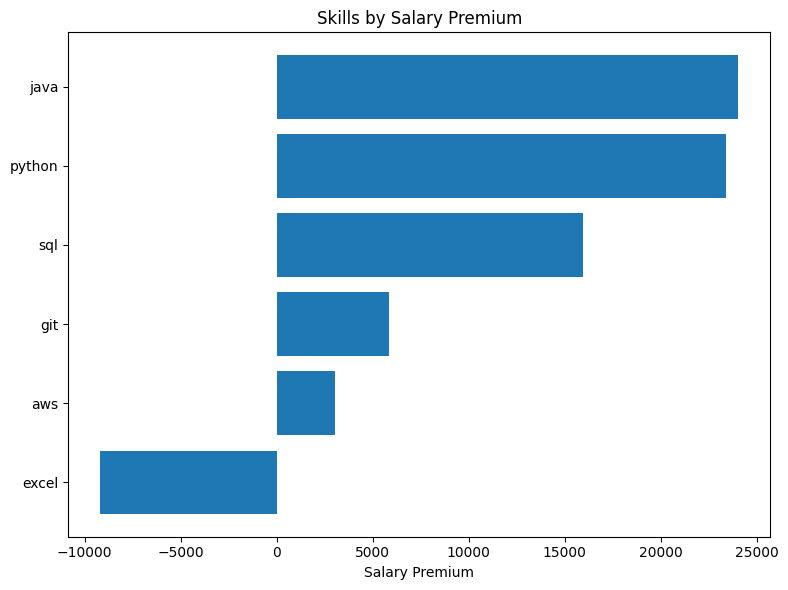

In [8]:
top_premium = (
    skill_salary_filtered
    .sort_values("salary_premium", ascending=False)
    .head(15)
)

plt.figure(figsize=(8,6))
plt.barh(top_premium["skill"], top_premium["salary_premium"])
plt.xlabel("Salary Premium")
plt.title("Skills by Salary Premium")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("skills_by_salary_premium.png")
plt.show()


### View 2: Demand vs salary premium

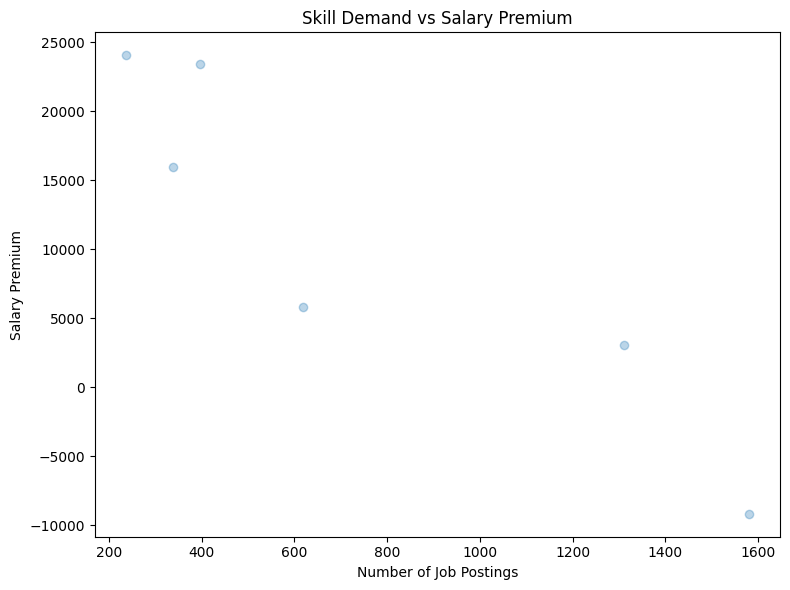

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(
    skill_salary_filtered["job_count"],
    skill_salary_filtered["salary_premium"],
    alpha=0.3
)
plt.xlabel("Number of Job Postings")
plt.ylabel("Salary Premium")
plt.title("Skill Demand vs Salary Premium")
plt.tight_layout()
plt.savefig("demand_vs_salary_premium.png")
plt.show()


## Interpretation

- A small set of programming skills (Java, Python, SQL) show the highest salary premiums.

- High-demand skills such as Excel and AWS offer lower or negative salary premiums despite widespread usage.

- Salary premiums are not directly correlated with job frequency.

- Scarcer skills tend to command higher compensation.

- This indicates that specialization yields better salary outcomes than general-purpose tools.